In [2]:
import numpy as np
import pandas as pd
import sys
import os
import csv
import ipdb
import pickle
from collections import OrderedDict, defaultdict
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [3]:
CONFIG = {
    'week': 'week12',
    'current_week': 12
}

In [4]:
df = pd.read_csv('outputs/analysis_lists/all_analysis_week_12.csv')

policies = ['rmab', 'control', 'round_robin']
T = 12

engagement_matrix = {pol:[] for pol in policies}
for pol in policies:
    for week in range(T):
        df[f'mat-{week}'] = df[f'week{week}_E/C'].apply(lambda x: int(x[0]))
        mat_cols = [col for col in df.columns if col.startswith('mat')] 
        engagement_matrix[pol] = (df[df['arm']==pol][mat_cols].values>0).astype(int)

In [5]:
df2 = pd.read_csv('outputs/individual_clustering/weekly_kmeans_pilot_stats_40.csv')

# weeks = ['week1', 'week2', 'week3', 'week4', 'week5']
# intervened_ppl = df[df['intervention_week'].isin(weeks)]['user_id']


rmab_list = pd.read_csv('outputs/pilot_outputs/rmab_pilot.csv')['user_id'].to_list()
round_robin_list = pd.read_csv('outputs/pilot_outputs/round_robin_pilot.csv')['user_id'].to_list()
control_list = pd.read_csv('outputs/pilot_outputs/control_pilot.csv')['user_id'].to_list()


rmab_group = df[df['user_id'].isin(rmab_list)]
# rmab_group = rmab_group[rmab_group['user_id'].isin(intervened_ppl)]
rmab_group = rmab_group.sort_values('{}_whittle'.format(CONFIG['week']), ascending=False)

round_robin_group = df2[df2['user_id'].isin(round_robin_list)]
# round_robin_group = round_robin_group[round_robin_group['user_id'].isin(intervened_ppl)]
round_robin_group = round_robin_group.sort_values('registration_date', ascending=True)

rmab_user_ids = rmab_group['user_id'].to_list()
round_robin_user_ids = round_robin_group['user_id'].to_list()

In [6]:
round_robin_group.shape, rmab_group.shape

((7668, 10), (7668, 33))

In [19]:
pilot_pd_data = pd.read_csv("feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv", sep='\t')
class_based_features = ['phone_owner' , "language"]
numeric_features = ['enroll_gest_age', "enroll_delivery_status", 
                    'age_binned', 'g', 'p', 's', 'l', 'a', 'education', 'income_binned']

pilot_pd_data['income_binned'] = pilot_pd_data['income_bracket'].replace(
    dict(zip(['0-5000', '5000-10000', '10000-15000', '15000-20000',
        '20000-25000', '25000-30000', '30000 and above'], [0,1,2,3,4,5,6])))
pilot_pd_data['age_binned'] = pd.cut(pilot_pd_data['age'], bins=3, labels=False)


dummy = pd.get_dummies(pilot_pd_data[class_based_features], columns = class_based_features)
pilot_pd_data = pd.concat([pilot_pd_data.drop(columns = class_based_features), dummy], axis=1)
class_based_features = list(dummy.columns)

pilot_pd_data[numeric_features+class_based_features+['age']]



,enroll_gest_age,enroll_delivery_status,age_binned,g,p,s,l,a,education,income_binned,phone_owner_family,phone_owner_husband,phone_owner_neighbor,phone_owner_woman,language_2,language_3,language_5,age
0,13,0,0,2,1,0.0,1,0,2,1,0,0,0,1,1,0,0,23
1,14,0,0,1,0,0.0,0,0,3,1,0,0,0,1,1,0,0,19
2,8,0,0,1,0,0.0,0,0,2,1,0,0,0,1,0,1,0,20
3,11,0,0,2,1,0.0,1,0,4,1,0,0,0,1,0,1,0,25
4,31,0,0,3,2,0.0,2,0,7,1,0,0,0,1,1,0,0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23522,8,0,0,3,0,0.0,0,2,3,1,0,0,0,1,0,1,0,25
23523,39,0,0,1,0,0.0,0,0,5,2,0,0,0,1,1,0,0,21
23524,26,0,0,2,1,0.0,1,0,4,1,0,0,0,1,1,0,0,22
23525,21,0,0,1,0,0.0,0,0,3,1,0,0,0,1,1,0,0,26


In [18]:
pd.read_csv("feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv", sep='\t')['age']

0        23
1        19
2        20
3        25
4        28
         ..
23522    25
23523    21
23524    22
23525    26
23526    25
Name: age, Length: 23527, dtype: int64

In [20]:
import scipy.stats as stats


g1 = pilot_pd_data[pilot_pd_data['user_id'].isin(rmab_list)]
g2 = pilot_pd_data[pilot_pd_data['user_id'].isin(round_robin_list)]
g3 = pilot_pd_data[pilot_pd_data['user_id'].isin(control_list)]


feat_sig_df = pd.DataFrame(columns = ['Feature', 'RMAB Group Mean','Round Robin Group Mean', 'Control Group Mean', 'Joint p-value'])

print('NUMERIC FEATURES STATS')
for f in numeric_features+class_based_features+['age']:
    print('-'*60)
    print('Feature {}'.format(f))
    print('G1: Mean - {}, Std - {}'.format(g1[f].mean(), g1[f].std()))
    print('G2: Mean - {}, Std - {}'.format(g2[f].mean(), g2[f].std()))
    print('G3: Mean - {}, Std - {}'.format(g3[f].mean(), g3[f].std()))
    p, f_val = stats.f_oneway(g1[f], g2[f], g3[f])
    print(f'p-value: {p}, f-value: {f_val}')
    if np.isnan(p):
        continue
    if f in ['language_5', 'age_binned']:
        continue
    feat_sig_df.loc[len(feat_sig_df)] = [f, np.round(g1[f].mean(), 3), np.round(g2[f].mean(), 3), np.round(g3[f].mean(), 3), np.round(p, 3)]

feat_sig_df


NUMERIC FEATURES STATS
------------------------------------------------------------
Feature enroll_gest_age
G1: Mean - 20.32303077725613, Std - 9.582281515959409
G2: Mean - 20.45409494001043, Std - 9.55710795336926
G3: Mean - 20.324768488326594, Std - 9.616568438330738
p-value: 0.4716117467294041, f-value: 0.6240017683847932
------------------------------------------------------------
Feature enroll_delivery_status
G1: Mean - 0.14580073030777257, Std - 0.35292934330590936
G2: Mean - 0.14149713093375066, Std - 0.3485563610637335
G3: Mean - 0.14855875831485588, Std - 0.35567619213239654
p-value: 0.7820194018916063, f-value: 0.45749340311596853
------------------------------------------------------------
Feature age_binned
G1: Mean - 0.12754303599374023, Std - 0.33477290547321653
G2: Mean - 0.12428273343766301, Std - 0.3307150548534484
G3: Mean - 0.1317334028955263, Std - 0.33899324233763056
p-value: 0.953997404406983, f-value: 0.38521339074451466
-----------------------------------------

,Feature,RMAB Group Mean,Round Robin Group Mean,Control Group Mean,Joint p-value
0,enroll_gest_age,20.323,20.454,20.325,0.472
1,enroll_delivery_status,0.146,0.141,0.149,0.782
2,g,1.675,1.686,1.705,1.373
3,p,0.678,0.673,0.696,1.570
4,s,0.017,0.019,0.018,0.242
5,l,0.645,0.637,0.662,1.715
6,a,0.036,0.033,0.031,0.901
7,education,3.531,3.490,3.477,2.961
8,income_binned,1.517,1.517,1.499,0.673
9,phone_owner_family,0.013,0.013,0.014,0.084


In [9]:
columns = numeric_features+class_based_features + ["exp_arm_rmab","exp_arm_rr"]
pilot_user_ids = df.user_id
# with open('policy_dump.pkl', 'rb') as fr:
#     pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
# fr.close()

pilot_static_features = pilot_pd_data[pilot_pd_data['user_id'].isin(pilot_user_ids)][numeric_features+class_based_features+['user_id']]
pilot_static_features = pilot_static_features.set_index('user_id')
pilot_static_features = pilot_static_features.loc[pilot_user_ids].values

arm_to_cat = {'rmab': [1,0], 'round_robin': [0,1], 'control': [0,0]}
full_mat = {'rmab': [], 'round_robin': [], 'control': []}


In [10]:
X_mat, Y_mat = [], [[] for i in range(1,13)]

mask = {'rmab':[0]*len(pilot_user_ids), 'round_robin':[0]*len(pilot_user_ids), 'control':[0]*len(pilot_user_ids)}
ctr = 0
for idx, user_id in tqdm(enumerate(pilot_user_ids)):

    curr_mat = []
    curr_row = df[df['user_id'] == user_id]

    arm = curr_row['arm'].item()
    count = 0

    week0e = int(curr_row['week{}_E/C'.format(0)].item().split('/')[0])

    if week0e:
        curr_mat.append(1)
        count += 1
    else:
        curr_mat.append(0)
    Y_mat[0].append(curr_mat[0])
    for i in range(1,12):
        nume = int(curr_row['week{}_E/C'.format(i)].item().split('/')[0])
        if nume > 0:
            count += 1
            curr_mat.append(1)
        else:
            curr_mat.append(0)
        Y_mat[i].append(count)
    X_mat.append(list(pilot_static_features[idx, :]) + arm_to_cat[arm])

    mask[arm][ctr] = 1
    ctr+=1

    full_mat[arm].append(np.array(curr_mat, dtype=np.int))

mask = {i:np.array(mask[i][:ctr]) for i in mask}
X_mat = np.array(X_mat)
Y_mat = np.array(Y_mat)


23003it [00:21, 1047.78it/s]


In [11]:
print('With Feat Reduction')
for t in range(1,12):
    print(f'Significance for T = {t}')
    print('\tRMAB vs RR')
    Y_mat_df = pd.DataFrame(Y_mat[t][mask['control']==0]-(t+1)*Y_mat[0][mask['control']==0], columns = ['output'])
    X_mat_df = pd.DataFrame(X_mat[mask['control']==0][:, :-1], columns = columns[:-1])

    mod = sm.OLS(Y_mat_df,sm.add_constant(X_mat_df))
    fii = mod.fit()
    var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[-1]
    print(f'\tCoef: {coef}, p_val: {p_val}')
    print('\n')
    print('\tRMAB vs Control')
    Y_mat_df = pd.DataFrame(Y_mat[t][mask['round_robin']==0]-(t+1)*Y_mat[0][mask['round_robin']==0], columns = ['output'])
    X_mat_df = pd.DataFrame(X_mat[mask['round_robin']==0][:, :-1], columns = columns[:-1])

    mod = sm.OLS(Y_mat_df,sm.add_constant(X_mat_df))
    fii = mod.fit()
    var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[-1]
    print(f'\tCoef: {coef}, p_val: {p_val}')
    print('\n')
    print('\tRR vs Control')
    Y_mat_df = pd.DataFrame(Y_mat[t][mask['rmab']==0]-(t+1)*Y_mat[0][mask['rmab']==0], columns = ['output'])
    X_mat_df = pd.DataFrame(np.concatenate([X_mat[mask['rmab']==0][:, :-2],
                                            X_mat[mask['rmab']==0][:, -1:]], axis=1),
                            columns = columns[:-2]+columns[-1:])

    mod = sm.OLS(Y_mat_df,sm.add_constant(X_mat_df))
    fii = mod.fit()
    var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[-1]
    print(f'\tCoef: {coef}, p_val: {p_val}')
    print('\n\n')

With Feat Reduction
Significance for T = 1
	RMAB vs RR
	Coef:     0.0133, p_val:  0.056


	RMAB vs Control
	Coef:     0.0121, p_val:  0.084


	RR vs Control
	Coef:    -0.0013, p_val:  0.848



Significance for T = 2
	RMAB vs RR
	Coef:     0.0309, p_val:  0.013


	RMAB vs Control
	Coef:     0.0296, p_val:  0.018


	RR vs Control
	Coef:    -0.0015, p_val:  0.905



Significance for T = 3
	RMAB vs RR
	Coef:     0.0400, p_val:  0.027


	RMAB vs Control
	Coef:     0.0344, p_val:  0.055


	RR vs Control
	Coef:    -0.0057, p_val:  0.754



Significance for T = 4
	RMAB vs RR
	Coef:     0.0515, p_val:  0.030


	RMAB vs Control
	Coef:     0.0394, p_val:  0.093


	RR vs Control
	Coef:    -0.0121, p_val:  0.609



Significance for T = 5
	RMAB vs RR
	Coef:     0.0588, p_val:  0.045


	RMAB vs Control
	Coef:     0.0561, p_val:  0.054


	RR vs Control
	Coef:    -0.0027, p_val:  0.928



Significance for T = 6
	RMAB vs RR
	Coef:     0.0618, p_val:  0.078


	RMAB vs Control
	Coef:     0.0646, p_val:  0

In [30]:
print('\tRMAB vs Control')
t=7
Y_mat_df = pd.DataFrame(Y_mat[t][mask['control']==0]-(t+1)*Y_mat[0][mask['control']==0], columns = ['output'])
X_mat_df = pd.DataFrame(X_mat[mask['control']==0][:, :-1], columns = columns[:-1])

mod = sm.OLS(Y_mat_df,sm.add_constant(X_mat_df))
fii = mod.fit()
var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[-1]
print(f'\tCoef: {coef}, p_val: {p_val}')

	RMAB vs Control
	Coef:     0.0680, p_val:  0.098


In [83]:
interv_df = pd.DataFrame(columns=['user_id', 'intervene_week', 'intervene_date', 'exp_group'])
interv_calling_files = ['250_week1_290421', '400_week2_060521', '400_week3_120521', '400_week4_180521', '435_week5_240521', '600_week6_310521', '700_week7_070621', '1000_week8_140621', '1000_week9_210621', '1000_week10_280621', '1000_week11_050721']

from datetime import datetime
week_date_lookup = {f.split('_')[1]:datetime.strptime(f.split('_')[-1], '%d%m%y') for f in interv_calling_files}

for file in interv_calling_files:
    with open('outputs/pilot_generations/calling_list_{}.txt'.format(file), 'r') as fr:
        for line in fr:
            user_id = int(line.strip())
            interv_week = file.split('_')[1]
            exp_group = df[df['user_id']==user_id]['arm'].iloc[0]
            intervene_date = week_date_lookup[interv_week]
            interv_df = interv_df.append({'user_id': user_id, 'intervene_week': interv_week, 'intervene_date':intervene_date, 'exp_group': exp_group}, ignore_index=True)


In [61]:
sub = interv_df[interv_df['intervene_week'].isin(week_list)]
sub[~sub['user_id'].duplicated()]['exp_group'].value_counts(), sub['exp_group'].value_counts()

(rmab           500
 round_robin    489
 Name: exp_group, dtype: int64,
 rmab           525
 round_robin    525
 Name: exp_group, dtype: int64)

In [88]:
print('\tRMAB vs Control')
t=7
week_list = [f'week{i}' for i in range(1, t)]
int_benefs = interv_df[interv_df['intervene_week'].isin(week_list)]['user_id'].unique()
# int_benefs = interv_df['user_id'].unique()
print(len(int_benefs))
Y_mat_df = pd.DataFrame(Y_mat[t][pilot_user_ids.isin(int_benefs)]-(t+1)*Y_mat[0][pilot_user_ids.isin(int_benefs)], columns = ['output'])
X_mat_df = pd.DataFrame(X_mat[pilot_user_ids.isin(int_benefs)][:, :-1], columns = columns[:-1])

mod = sm.OLS(Y_mat_df,sm.add_constant(X_mat_df))
fii = mod.fit()
var, coef, std_err, t_val, p_val, q1, q3 = fii.summary().tables[1].data[-1]
print(f'\tCoef: {coef}, p_val: {p_val}')

	RMAB vs Control
2238
	Coef:     0.1450, p_val:  0.234


In [86]:
mask['control']==0

15336

In [64]:
pilot_user_ids

0        2394384
1        2396341
2        2395407
3        2405773
4        2391765
          ...   
22998    2402502
22999    2391003
23000    2390953
23001    2385630
23002    2390819
Name: user_id, Length: 23003, dtype: int64

In [77]:
fii.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 output   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.072
Date:                Wed, 01 Sep 2021   Prob (F-statistic):              0.369
Time:                        19:44:17   Log-Likelihood:                -30731.
No. Observations:               15335   AIC:                         6.151e+04
Df Residuals:                   15312   BIC:                         6.168e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0998      0.204      0.489      0.625      -0.300       0.500
enroll_gest_age           -0.0016      0.002     -0.971      0.332      -0.005       0.002
enroll_delivery_status    -0.0157      0.047     -0.335      0.738      -0.108       0.076
age_binned                 0.0028      0.028      0.102      0.918      -0.051       0.057
g                          0.0170      0.016      1.037      0.300      -0.015       0.049
p                         -0.0605      0.106     -0.569      0.569      -0.269       0.148
s                          0.1053      0.138      0.761      0.447      -0.166       0.377
l                          0.0264      0.107      0.247      0.805      -0.183       0.236
a                         -0.0867      0.067     -1.294      0.196      -0.218       0.045
education                  0.0070      0.010      0.676      0.499      -0.013       0.027
income_binned             -0.0035      0.015     -0.231      0.817      -0.033       0.026
ChannelType_ARMMAN      1.517e-15   2.64e-15      0.576      0.565   -3.65e-15    6.68e-15
ChannelType_Community      0.0609      0.104      0.586      0.558      -0.143       0.264
ChannelType_Hospital       0.0389      0.103      0.377      0.706      -0.163       0.241
phone_owner_family        -0.0237      0.411     -0.058      0.954      -0.830       0.783
phone_owner_husband       -0.2978      0.402     -0.740      0.459      -1.086       0.490
phone_owner_neighbor       0.7760      1.398      0.555      0.579      -1.965       3.517
phone_owner_woman         -0.3548      0.401     -0.885      0.376      -1.140       0.431
call_slots_1              -0.0304      0.050     -0.606      0.545      -0.129       0.068
call_slots_2               0.0021      0.057      0.037      0.971      -0.111       0.115
call_slots_3              -0.0027      0.043     -0.061      0.951      -0.087       0.082
call_slots_4               0.0380      0.050      0.765      0.444      -0.059       0.135
call_slots_5               0.1025      0.052      1.982      0.047       0.001       0.204
call_slots_6              -0.0098      0.047     -0.208      0.835      -0.102       0.083
language_2                 0.0384      0.087      0.441      0.659      -0.132       0.209
language_3                 0.0391      0.088      0.446      0.656      -0.133       0.211
language_5                 0.0223      0.149      0.150      0.881      -0.269       0.313
exp_arm_rmab               0.0555      0.029      1.912      0.056      -0.001       0.112
==============================================================================
Omnibus:                      688.675   Durbin-Watson:                   1.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1939.612
Skew:                    

In [ ]:
import matplotlib.pyplot as plt
for pol in ['control' , 'rmab','round_robin' ]:
    plt.plot(range(1,11), [(Y_mat[week][mask[pol]==1]- Y_mat[week-1][mask[pol]==1] - Y_mat[0][mask[pol]==1]).sum() for week in range(1, 11)],
             '-^', label=pol)
plt.title('Engagement Drop')
plt.legend()

plt.figure()
for pol in ['control' , 'rmab','round_robin' ]:
    plt.plot(range(11), [(Y_mat[week][mask[pol]==1] - (week+1)*Y_mat[0][mask[pol]==1]).sum() for week in range(11)],
             '-^', label=pol)
plt.title('Cumulative Engagement Drop')
plt.legend()

plt.figure()
import matplotlib.pyplot as plt
for pol in ['control' , 'rmab','round_robin' ]:
    plt.plot(range(11), [Y_mat[week][mask[pol]==1].sum() for week in range(11)],
             '-^', label=pol)
plt.legend()
plt.title('Cumulative Engagement')

In [84]:
inst_engag_drop = dict(zip(['control' , 'rmab','round_robin' ], [{}, {}, {}]))
cumu_engag_drop = dict(zip(['control' , 'rmab','round_robin' ], [{}, {}, {}]))
for pol in ['control' , 'rmab','round_robin' ]:
    for week in range(1,11):
        inst_engag_drop[pol][week] = Y_mat[week][mask[pol]==1] - Y_mat[week-1][mask[pol]==1] - Y_mat[0][mask[pol]==1]
        cumu_engag_drop[pol][week] = Y_mat[week][mask[pol]==1] - (week+1)*Y_mat[0][mask[pol]==1]

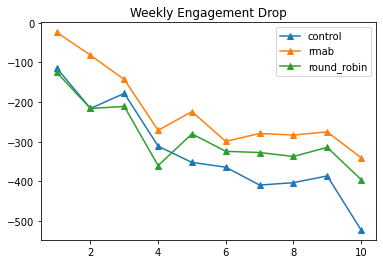

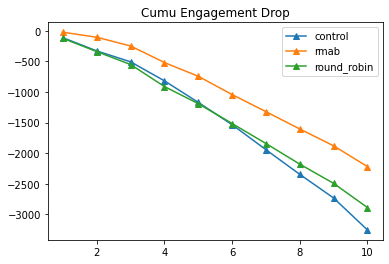

In [86]:
plt.figure()
import matplotlib.pyplot as plt
for pol in ['control' , 'rmab','round_robin' ]:
    plt.plot(range(1,11), [inst_engag_drop[pol][week].sum() for week in range(1, 11)],
             '-^', label=pol)
    
plt.title('Weekly Engagement Drop')
plt.legend()

plt.figure()
import matplotlib.pyplot as plt
for pol in ['control' , 'rmab','round_robin' ]:
    plt.plot(range(1,11), [cumu_engag_drop[pol][week].sum() for week in range(1, 11)],
             '-^', label=pol)
    
plt.title('Cumu Engagement Drop')
plt.legend()

(array([ 217.,  256.,  330.,  410.,  648., 4265.,  638.,  350.,  261.,
         292.]),
 array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <BarContainer object of 10 artists>)

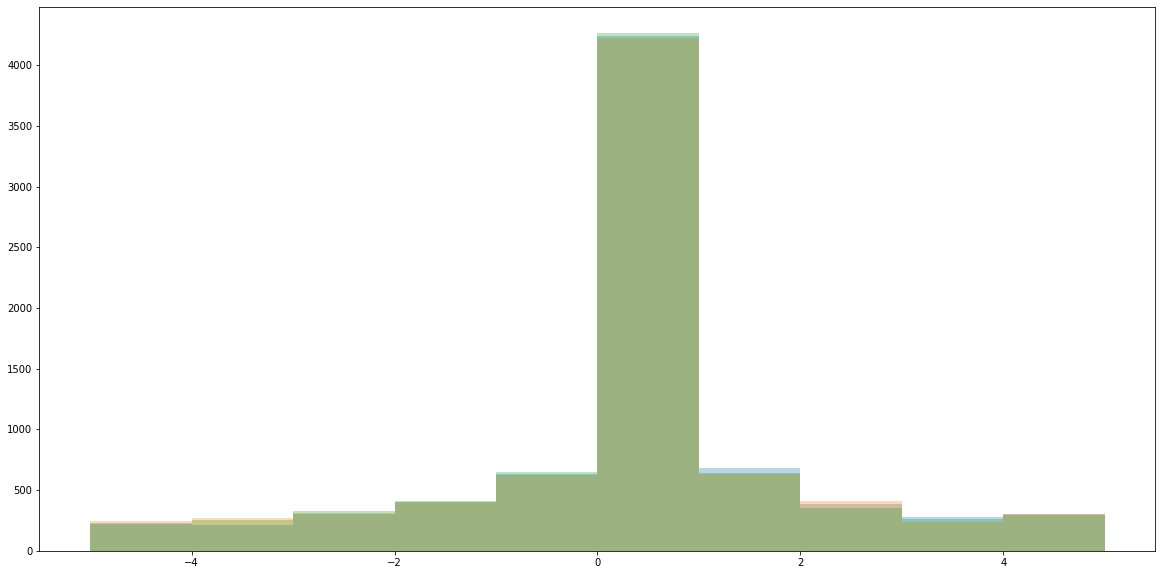

In [100]:
plt.figure(figsize=(20,10))
plt.hist(cumu_engag_drop['rmab'][5], label='rmab', alpha=0.3)
plt.hist(cumu_engag_drop['round_robin'][5], label='round_robin', alpha=0.3)
plt.hist(cumu_engag_drop['control'][5], label='control', alpha=0.3)

In [101]:
print(pd.Series(cumu_engag_drop['rmab'][5]).value_counts())
print(pd.Series(cumu_engag_drop['round_robin'][5]).value_counts())
print(pd.Series(cumu_engag_drop['control'][5]).value_counts())

 0    4244
 1     681
-1     631
-2     405
 2     383
-3     300
 3     275
-5     231
-4     216
 4     166
 5     136
dtype: int64
 0    4224
 1     634
-1     625
 2     411
-2     398
-3     315
-4     274
-5     246
 3     241
 4     179
 5     121
dtype: int64
 0    4265
-1     648
 1     638
-2     410
 2     350
-3     330
 3     261
-4     256
-5     217
 4     185
 5     107
dtype: int64


In [102]:
cumu_engag_drop['rmab'][5].sum(), cumu_engag_drop['rmab'][5].mean(), cumu_engag_drop['rmab'][5].std()

(-744, -0.09702660406885759, 1.8003438278879067)